### Getting the data

For this homework, we will download the Car Fuel Efficiency dataset:

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-04 08:33:41--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.006s  

2025-10-04 08:33:42 (149 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



### Preparing the dataset 

In [ ]:
# Import libraries 
import pandas as pd 
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
car_fuel = pd.read_csv('car_fuel_efficiency.csv')

The goal of this homework is to create a regression model for predicting the car fuel efficiency (column `fuel_efficiency_mpg`).

We only use the following columns:
- `engine_displacement`
- `horsepower`
- `vehicle_weight`
- `model_year`
- `fuel_efficiency_mpg`

In [35]:
df = car_fuel[['engine_displacement','horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


### EDA

Now we investigate the `fuel_efficiency_mpg` variable.

[Text(0.5, 1.0, 'Fuel Efficiency Distribution')]

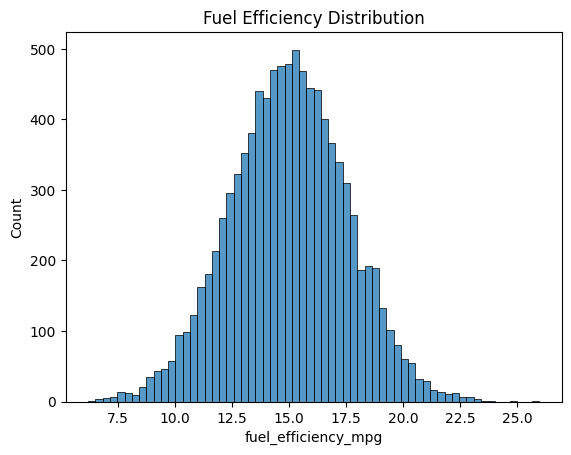

In [5]:
sns.histplot(df['fuel_efficiency_mpg']).set(title='Fuel Efficiency Distribution')

Does it have a long tail? **No**, it looks approxiamtely normal and does not have a clear long tail.

### Question 1

Next, we inspect the **missing values** statistics:

In [6]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

It is clear that only one column has a fairly high number of missing values so let's answer the question:

There's one column with missing values. What is it? **`horsepower`**

### Question 2

In [7]:
df['horsepower'].quantile(0.5)

np.float64(149.0)

What's the median (50% percentile) for variable `horsepower`? **149.0**

#### Prepare and split the dataset

- Shuffle the dataset (the filtered one you created above), use seed `42`.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [36]:
n = len(df) 

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test 

n_val, n_test, n_train

(1940, 1940, 5824)

In [37]:
idx = np.arange(n)
idx

array([   0,    1,    2, ..., 9701, 9702, 9703], shape=(9704,))

In [38]:
np.random.seed(42)
np.random.shuffle(idx)

In [39]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [40]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [41]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [42]:
y_train = np.log1p(df_train['fuel_efficiency_mpg'].values)
y_val = np.log1p(df_val['fuel_efficiency_mpg'].values)
y_test = np.log1p(df_test['fuel_efficiency_mpg'].values)

In [43]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [44]:
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

### Question 3

Now we deal with **missing values** for the column from Q1 with two options: 
- Fill it with `0` or 
- Fill it with the `mean` of this variable.

Specifically, we will try both options; each will be trained a **_linear regression model_**.

**Note:** 
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the `RMSE` of each option.
- Round the `RMSE` scores to 2 decimal digits using round(score, 2) to point out better option.

The `train_linear_regression` and `rmse` function from the lessons:

In [45]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

#### Option 1: Fill missing values with 0

Fill missing horsepower with 0

In [46]:
X_train_0 = df_train.fillna({'horsepower': 0})
X_val_0 = df_val.fillna({'horsepower': 0})

In [47]:
# Train model
w_0, w = train_linear_regression(X_train_0.values, y_train)

In [48]:
y_pred_0 = w_0 + X_val_0.dot(w)

<Axes: ylabel='Count'>

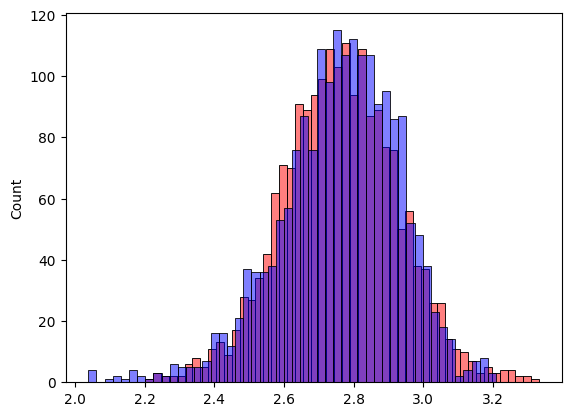

In [55]:
sns.histplot(y_pred_0, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

In [58]:
rmse_0 = rmse(y_val, y_pred_0)

#### Option 2: Fill missing values with Means

Fill NaN with the mean horsepower

In [52]:
mean_hp = df_train['horsepower'].mean()

X_train_mean = df_train.fillna({'horsepower': mean_hp})
X_val_mean = df_val.fillna({'horsepower': mean_hp})

In [53]:
# Train model
w_mean, w = train_linear_regression(X_train_mean.values, y_train)

In [54]:
y_pred_mean = w_mean + X_val_mean.dot(w)

<Axes: ylabel='Count'>

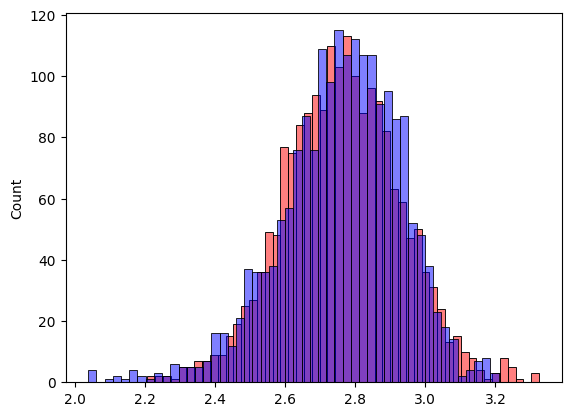

In [56]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

In [59]:
rmse_mean = rmse(y_val, y_pred_mean)

In [60]:
print("RMSE (fill=0):", round(rmse_0, 2))
print("RMSE (fill=mean):", round(rmse_mean, 2))

RMSE (fill=0): 0.04
RMSE (fill=mean): 0.04


Based on the perfomance outcomes, we can now answer the question: 

Which option gives better RMSE? **Both are equally good**

### Question 4